**5. Анализ результатов. ЗАДАНИЯ.**


# Описание задачи

## Информация из предыдущих этапов

**Постановка кейса.**

В рамках практических заданий мы будем работать аналитиком на платформе по подаче объявлений. По результатам исследований мы выяснили, что недавно введенной функцией доставки пользуются редко. В рамках идей по исправлению ситуации была предложена инициатива выдать скидку в 20% на данную услугу, зачеркнув старую цену и написав рядом новую на карточках объявлений, в которых доступна доставка. Нам поставлена задача оценить данную инициативу.

**Метрики.**

По резульатам командного обсуждения было принято назначить целевой метрикой выручку. Прочие метрики, за которыми ваша команда планирует наблюдать: выручка с доставки, пользователи с доставкой, количество ошибок на экранах доставочный айтемов, количество заказов без доставки.

**Критерий.**

По результатам предыдущего исследования наш выбор пал на тест Стьюдента. Предполагаем, что будем использовать его.

**MDE, N, alpha, beta**

По результатам обсуждения с аналитиками и продуктами было принято решение остановиться на ошибках 1 и 2 рода в 1% при MDE в 1.4% для основной метрики. N = 5 mln в каждой группе, длительность эксперимента - 21 день.

**Разбиение на тест-контроль**

Мы реализовали функцию деления выборки на тест-контроль с помощью остатка от деления от хэша id юзера и соли эксперимента. При этом мы модифицировали функцию так, чтобы данные до начала эксперимента не отличались между собой статистически значимо ни по одной метрике.

## Текущее задание

**Анализ результатов.**

Ваш коллега проанализировал тест, и оказалось, что ни по 1 метрике не обнаружилось статистически значимой разницы. Хотя тестовая группа и выигрывала по целевой и прокси-метрикам, доверительный интервал перекрывал 0, p value был значительно выше 0.05.

Следующим этапом было решено проанализировать наиболее чувствительный сегмент. Ваши коллеги подготовили такую выборку, на которую тестовое воздействие должно было повлиять наибольшим образом. В нее попали те пользователи, что находятся в удаленых регионах и переходили на карточки объявлений с возможностью доставки. То есть этим юзерам актуальна доставка, и они точно видели тестовое воздействие (или потенциально увидели бы его, если речь идет о контроле). Проанализируйте эти данные (task_5) и сделайте вывод!

Суммарно можно получить более 10 баллов. Помимо непосредственно заданий есть скрытые баллы, которые можно получить, если писать хороший код и делать то, о чем говорилось на лекциях. При этом оценка будет рассчитываться из расчета, что 9 баллов - это 100% выполнения.

In [2]:
import pandas as pd
import numpy as np
from collections import namedtuple
from scipy.stats import norm, chisquare
from statsmodels.stats.proportion import proportion_confint
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Проверка SRM. 1 балл

## Формулировка

Прежде чем проанализировать тест, убедимся в его здоровье, а именно - SRM. Убедитесь, что несоответствие коэффициента выборки не явлвяется статистически значимым.

In [3]:
task_5 = pd.read_csv('task_5.csv')
task_5.head()

,user_id,revenue,delivery_revenue,has_delivery,error_count,order_wo_delivery,is_test
0,5488135039,0.0,0.0,False,0,2,True
1,7151893663,0.0,0.0,False,0,2,True
2,6027633760,0.0,0.0,False,0,5,True
3,5448831829,0.0,0.0,False,0,0,True
4,4236547993,0.0,0.0,False,0,6,False


In [58]:
task_5['is_test'].value_counts()

is_test
False    25078
True     24922
Name: count, dtype: int64

Группы немного отличаются между собой, но нам нужно проверить, допустимо ли такое отличие

In [62]:
f_obs = task_5['is_test'].value_counts()
f_exp = [len(task_5)/ task_5['is_test'].nunique()] * task_5['is_test'].nunique()
chisquare(f_obs = f_obs, f_exp = f_exp)

Power_divergenceResult(statistic=0.48672, pvalue=0.48539409701354075)

### Вывод
Тест Хи-квадрат Пирсона показывает, что значимых отличий между количеством наблюдений в группах нет (так как P-value значительно больше 0,05.

# Анализ сбалансированности групп на пред-периоде. 1 балл

## Формулировка

Перед тем как проанализировать данные во время теста, давайте убедимся, что наши данные не отличались до теста (из-за фактора случайности или ошибки на каком-либо этапе). Для этого объедените данные из task_5 с task_1 по user_id и проверьте гипотезы о равенстве средних в тесте и контроле по данным из task_1.

In [3]:
task_1 = pd.read_csv('task_2.csv')
task_5 = pd.read_csv('task_5.csv')

In [8]:
data = task_1.merge(task_5, how='outer', on='user_id')
print(data.info())
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              50000 non-null  int64  
 1   revenue_x            50000 non-null  float64
 2   delivery_revenue_x   50000 non-null  float64
 3   has_delivery_x       50000 non-null  bool   
 4   error_count_x        50000 non-null  int64  
 5   order_wo_delivery_x  50000 non-null  int64  
 6   revenue_y            50000 non-null  float64
 7   delivery_revenue_y   50000 non-null  float64
 8   has_delivery_y       50000 non-null  bool   
 9   error_count_y        50000 non-null  int64  
 10  order_wo_delivery_y  50000 non-null  int64  
 11  is_test              50000 non-null  bool   
dtypes: bool(3), float64(4), int64(5)
memory usage: 3.6 MB
None


,user_id,revenue_x,delivery_revenue_x,has_delivery_x,error_count_x,order_wo_delivery_x,revenue_y,delivery_revenue_y,has_delivery_y,error_count_y,order_wo_delivery_y,is_test
0,5488135039,0.0,0.0,False,0,1,0.0,0.0,False,0,2,True
1,7151893663,0.0,0.0,False,0,1,0.0,0.0,False,0,2,True
2,6027633760,0.0,0.0,False,0,6,0.0,0.0,False,0,5,True
3,5448831829,0.0,0.0,False,0,3,0.0,0.0,False,0,0,True
4,4236547993,0.0,0.0,False,0,9,0.0,0.0,False,0,6,False


In [17]:
experiment_result = namedtuple(
    'experiment_result',
     ['pvalue', 'effect', 'left_bound', 'right_bound'],
)

def absolute_ttest(control, test, ci_level=0.05):
    mean_control = np.mean(control)
    mean_test = np.mean(test)
    var_mean_control  = np.var(control) / len(control)
    var_mean_test  = np.var(test) / len(test)
    difference_mean = mean_test - mean_control
    difference_mean_var = var_mean_control + var_mean_test
    difference_distribution = norm(loc=difference_mean, scale=np.sqrt(difference_mean_var))
    left_bound, right_bound = difference_distribution.ppf([ci_level / 2, 1 - ci_level / 2])
    pvalue = 2 * min(difference_distribution.cdf(0), difference_distribution.sf(0))
    effect = difference_mean
    return experiment_result(pvalue, effect, left_bound, right_bound)

In [19]:
metrics = ['revenue_x', 'delivery_revenue_x', 'has_delivery_x', 'error_count_x', 'order_wo_delivery_x']

for metric in metrics:
    pvalue, effect, left_bound, right_bound = absolute_ttest(data[data['is_test']==False][metric], data[data['is_test']==True][metric])
    print(f'''Метрика {metric}: p value = {pvalue}, эффект = {effect}, левая граница интервала = {left_bound}, правая граница интервала = {right_bound}''')

Метрика revenue_x: p value = 0.9149260787279342, эффект = 0.39770953113368535, левая граница интервала = -6.899088023287586, правая граница интервала = 7.694507085554955
Метрика delivery_revenue_x: p value = 0.7298834425285646, эффект = -0.7407424777221756, левая граница интервала = -4.945521573499151, правая граница интервала = 3.4640366180547986
Метрика has_delivery_x: p value = 0.3176425760169146, эффект = -0.001402391251437398, левая граница интервала = -0.004152914287453853, правая граница интервала = 0.001348131784579056
Метрика error_count_x: p value = 0.5409617799346518, эффект = 0.007807912805346415, левая граница интервала = -0.017223569290611588, правая граница интервала = 0.032839394901304414
Метрика order_wo_delivery_x: p value = 0.8043198740457429, эффект = -0.006168690448500325, левая граница интервала = -0.05496751396877946, правая граница интервала = 0.042630133071778806


### Вывод
В нашем примере метрики в тесте и контроле равны: P-value достаточно выходит, и во все доверительные интервалы входит 0.

# Относительный T-test: реализация и валидация. 3 балла

## Формулирвока

Ваши коллеги хотели бы делать вывод в процентах, а не абсолютах. Реализуйте относительную постановку t-test'a. Проверьте, что функция выдает ожидаемые результаты с помощью двух примеров, написанных ниже. Провалидируйте реализацию с помощью синтетических АА и АБ тестах на метрике 'revenue' из task_1: случайно разбивайте 50/50 и сравнивайте с помощью относительной постановки без изменений в случае АА и домножая на 1.2 (имитируя прирост в 20%) псевдотестовую группу в случае синтетичских АБ. Проделайте данную процедуру 10 тысяч раз и сделайте вывод о корректности критерия.

In [5]:
experiment_result = namedtuple(
    'experiment_result',
     ['pvalue', 'left_bound', 'effect', 'right_bound'],
)

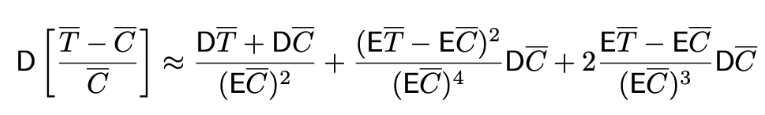

In [8]:
def relative_ttest(
    control: np.ndarray | pd.Series,
    test: np.ndarray | pd.Series,
    p_value_only: bool = False,
    ci_level: float = 0.05
    ) -> float | experiment_result:
    """
    Функция рассчитывает относительную постановку t-теста

    Входные параметры:
    control: np.ndarray или pd.Series - массив метрики по контрольной группе.
    test: np.ndarray или pd.Series - массив метрики по экспериментальной группе.
    p_value_only: bool - выводить ли только p value. По умолчанию - false:
      возвращается именовонный кортеж с размером эффекта и границами ДИ.
    ci_level: float - уровень значимости для расчета доверительного интервала
      для размера эффекта. 0.05 по умолчанию (будет считаться 95% ДИ).

    Возвращает в зависимости от флага p_value_only:
      float p value или namedtuple(p_value, left_bound, effect, right_bound)
    """
    mean_control = np.mean(control)
    var_mean_control  = np.var(control) / len(control)
    var_mean_test  = np.var(test) / len(test)
    difference_mean = np.mean(test) - mean_control
    
    rel_var_1_term = (var_mean_control + var_mean_test) / (mean_control ** 2)
    rel_var_2_term = var_mean_control * ((difference_mean ** 2) / (mean_control ** 4))
    rel_var_3_term = 2 * (difference_mean / (mean_control ** 3)) * var_mean_control
    relative_var =  rel_var_1_term + rel_var_2_term + rel_var_3_term
    
    effect = difference_mean / mean_control
    relative_distribution = norm(loc=effect, scale=np.sqrt(relative_var))
    left_bound, right_bound = relative_distribution.ppf([ci_level / 2, 1 - ci_level / 2])
    pvalue = 2 * min(relative_distribution.cdf(0), relative_distribution.sf(0))
    
    if p_value_only == True:
        return pvalue
    else:
        return experiment_result(pvalue, effect, left_bound, right_bound)

Проверяем, что функция работает

In [22]:
task_5_test = task_5[task_5['is_test']]
task_5_control = task_5[~ task_5['is_test']]

In [67]:
relative_ttest(
    control=task_5_control['revenue'],
    test=task_5_test['revenue'],
    p_value_only=True,
    )

0.07014509102230279

In [68]:
relative_ttest(
    control=task_5_control['delivery_revenue'],
    test=task_5_test['delivery_revenue'],
    p_value_only=False,
    ci_level=0.01
    )

experiment_result(pvalue=0.3222148538341155, left_bound=0.07262775217741808, effect=-0.11635451183822489, right_bound=0.261610016193061)

## Валидируем на синтетических АА и АБ тестах

In [37]:
p_values = []
POTENTIAL_EFFECT = 0.2
ALPHA = 0.05
effect_not_in_ci = 0
N_ITER = 10_000

fte = 0

for i in tqdm(range(N_ITER)):
    control, test = train_test_split(task_1['revenue'], test_size=0.5)
    _, _, left_bound, right_bound = relative_ttest(control, test)
    if left_bound > 0 or right_bound < 0:
        fte += 1   
    
left_real_level_fte, right_real_level_fte = proportion_confint(count=fte, nobs=N_ITER, alpha=ALPHA, method='wilson')

print(f"\nРеальный уровень значимости в АА-тестах: {round(fte / N_ITER, 4)};"
      f" доверительный интервал для ошибки 2 рода: [{round(left_real_level_fte, 4)}, {round(right_real_level_fte, 4)}]")

100%|██████████| 10000/10000 [00:58<00:00, 171.63it/s]


Реальный уровень значимости в АА-тестах: 0.0498; доверительный интервал для ошибки 2 рода: [0.0457, 0.0542]


In [43]:
ste = 0

for i in tqdm(range(N_ITER)):
    control, test = train_test_split(task_1['revenue'], test_size=0.5)
    test *= 1 + POTENTIAL_EFFECT
    _, _, left_bound, right_bound = relative_ttest(control, test)
    if left_bound > POTENTIAL_EFFECT or right_bound < POTENTIAL_EFFECT:
        ste += 1    
    
left_real_level_ste, right_real_level_ste = proportion_confint(count=ste, nobs=N_ITER, alpha=ALPHA, method='wilson')

print(f"\nРеальный уровень значимости в АБ-тестах: {round(ste / N_ITER, 4)};" 
      f" доверительный интервал для ошибки 1 рода: [{round(left_real_level_ste, 4)}, {round(right_real_level_ste, 4)}].")

100%|██████████| 10000/10000 [01:00<00:00, 165.35it/s]


Реальный уровень значимости в АБ-тестах: 0.0511; доверительный интервал для ошибки 1 рода: [0.047, 0.0556].


### Вывод
Функция работает корректно, заданные уровни ошибок не выходят из доверительного интервала.

# Анализ результатов и выводы. 4 балла.

## Формулировка

Наконец, пришла пора проанализировать результаты из task_5 за экспериментальный период и сделать выводы!

По резульатам командного обсуждения было принято назначить целевой метрикой выручку. Прочие метрики, за которыми ваша команда планирует наблюдать: выручка с доставки, пользователи с доставкой, количество ошибок на экранах доставочный айтемов, количество заказов без доставки.

In [10]:
metrics = ['revenue', 'delivery_revenue', 'has_delivery', 'error_count', 'order_wo_delivery']
test_result = {'p_value': [],         
    '99% low, %': [],
    'effect, %': [],
    '99% high, %': []}
for metric in metrics:
    test = task_5[task_5['is_test']][metric]
    control = task_5[~ task_5['is_test']][metric]
    result = relative_ttest(control, test, ci_level = 0.01)
    
    test_result['p_value'].append(result.pvalue)
    test_result['99% low, %'].append(result.left_bound*100)
    test_result['effect, %'].append(result.effect*100)
    test_result['99% high, %'].append(result.right_bound*100)

test_result = pd.DataFrame(test_result, index = metrics)   
test_result.style.format('{:.3f}').background_gradient(cmap = 'Blues', axis=0)

,p_value,"99% low, %","effect, %","99% high, %"
revenue,0.070,7.739,-3.268,18.746
delivery_revenue,0.322,7.263,-11.635,26.161
has_delivery,0.031,13.125,-2.542,28.792
error_count,0.508,9.065,-26.231,44.362
order_wo_delivery,0.678,-0.518,-3.736,2.700


### Вывод
Эффекты не попадают в доверительные интервалы при данном дизайне эксперимента. Был выбран неправильный дизайн эксперимента.